Data Exploration:
   Transaction_ID                 Date      Customer_Name  \
0      1000000000  2022-01-21 06:27:29       Stacey Price   
1      1000000001  2023-03-01 13:01:21   Michelle Carlson   
2      1000000002  2024-03-21 15:37:04        Lisa Graves   
3      1000000003  2020-10-31 09:59:47  Mrs. Patricia May   
4      1000000004  2020-12-10 00:59:59     Susan Mitchell   

                                             Product  Total_Items  Total_Cost  \
0        ['Ketchup', 'Shaving Cream', 'Light Bulbs']            3       71.65   
1  ['Ice Cream', 'Milk', 'Olive Oil', 'Bread', 'P...            2       25.93   
2                                        ['Spinach']            6       41.49   
3                             ['Tissues', 'Mustard']            1       39.34   
4                                      ['Dish Soap']           10       16.42   

   Payment_Method           City        Store_Type Discount_Applied  \
0  Mobile Payment    Los Angeles    Warehouse Club       

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


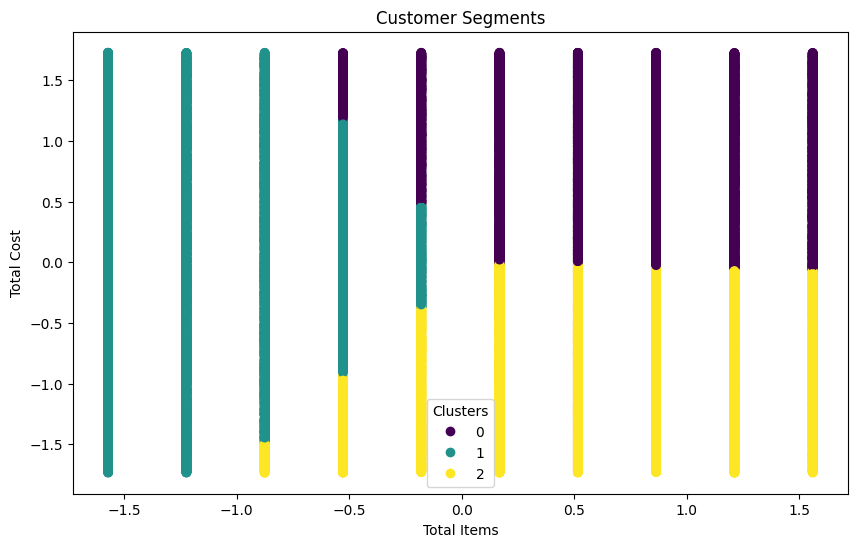

Epoch 1/20
32/32 [==============================] - 5s 13ms/step - loss: 0.0730
Epoch 2/20
32/32 [==============================] - 1s 17ms/step - loss: 0.0350
Epoch 3/20
32/32 [==============================] - 1s 22ms/step - loss: 0.0310
Epoch 4/20
32/32 [==============================] - 1s 21ms/step - loss: 0.0307
Epoch 5/20
32/32 [==============================] - 1s 21ms/step - loss: 0.0279
Epoch 6/20
32/32 [==============================] - 1s 23ms/step - loss: 0.0301
Epoch 7/20
32/32 [==============================] - 1s 22ms/step - loss: 0.0267
Epoch 8/20
32/32 [==============================] - 1s 20ms/step - loss: 0.0252
Epoch 9/20
32/32 [==============================] - 0s 13ms/step - loss: 0.0287
Epoch 10/20
32/32 [==============================] - 0s 12ms/step - loss: 0.0260
Epoch 11/20
32/32 [==============================] - 0s 12ms/step - loss: 0.0340
Epoch 12/20
32/32 [==============================] - 0s 13ms/step - loss: 0.0253
Epoch 13/20
32/32 [==================

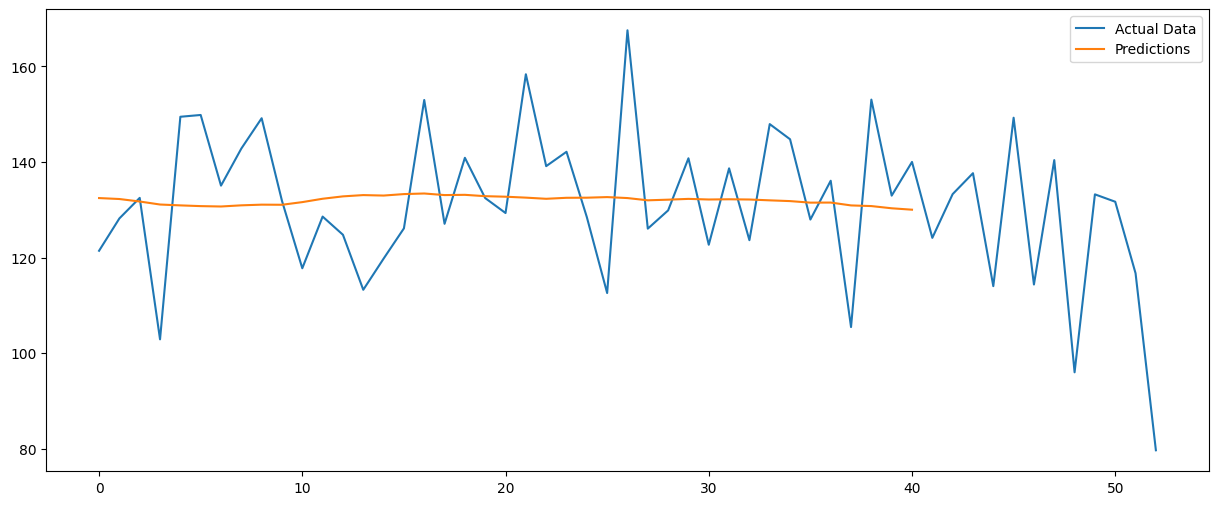

1/1 [==============================] - 0s 26ms/step
Lead Predictions for the next month:
[138.9206]
Prediction RMSE: 23.561376829698894
Prediction MAE: 18.26861462793589


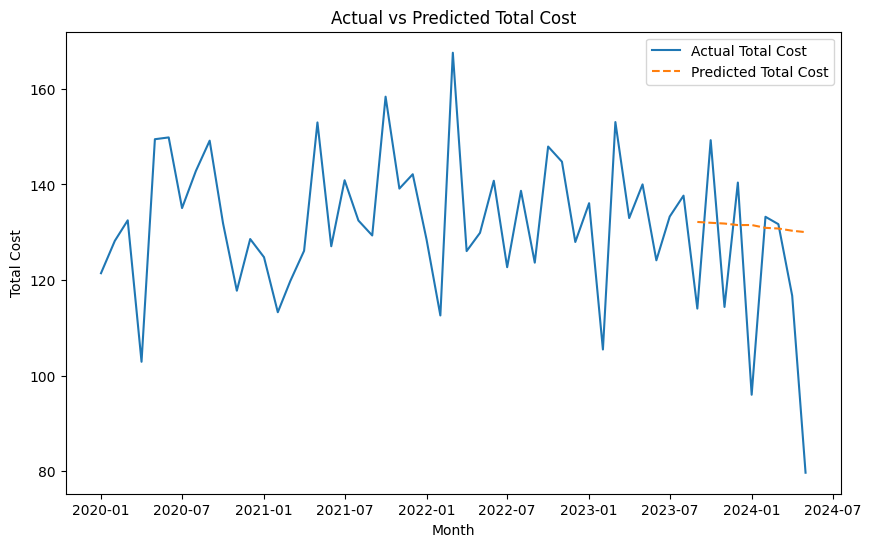

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.optimizers import Adam
from sklearn.metrics import mean_absolute_error, r2_score
def create_sequences(data, seq_length):
    xs = []
    ys = []
    for i in range(len(data) - seq_length):
        x = data[i:i + seq_length]
        y = data[i + seq_length]
        xs.append(x)
        ys.append(y)
    return np.array(xs), np.array(ys)


data_path ='/content/Retail_Transactions_Dataset.csv'
df = pd.read_csv(data_path)

# Data Exploration
print("Data Exploration:")
print(df.head())
print(df.describe())

# Data Cleaning
df['Total_Cost'] = df['Total_Cost'].astype(float)

# Correct datetime parsing format
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d %H:%M:%S')

# handling missing values
imputer = SimpleImputer(strategy='mean')
df[['Total_Items', 'Total_Cost']] = imputer.fit_transform(df[['Total_Items', 'Total_Cost']])

# Check for negative values(outliers detection)
if (df[['Total_Items', 'Total_Cost']] < 0).any().any():
    raise ValueError("Negative values found in Total_Items or Total_Cost. Check data quality.")

df = pd.get_dummies(df, columns=['Payment_Method', 'City', 'Store_Type', 'Customer_Category', 'Season', 'Promotion'], drop_first=True)

scaler = StandardScaler()
numerical_columns = ['Total_Items', 'Total_Cost']
df[numerical_columns] = scaler.fit_transform(df[numerical_columns])

# Clustering for Microsegmentation
k = 3
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(df[numerical_columns])
df['Cluster'] = kmeans.labels_

# Visualize the clusters
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['Total_Items'], df['Total_Cost'], c=df['Cluster'], cmap='viridis')
plt.xlabel('Total Items')
plt.ylabel('Total Cost')
plt.title('Customer Segments')
plt.legend(*scatter.legend_elements(), title="Clusters")
plt.show()

#hypertargetting
df['Month'] = df['Date'].dt.to_period('M')

# Selecting the numerical columns and  cluster them
group_columns = ['Month', 'Cluster'] + numerical_columns
monthly_data = df[group_columns].groupby(['Month', 'Cluster']).sum().reset_index()
monthly_data['Month'] = monthly_data['Month'].dt.to_timestamp()

cluster_id = 0
cluster_data = monthly_data[monthly_data['Cluster'] == cluster_id]

scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(cluster_data['Total_Cost'].values.reshape(-1, 1))

seq_length = 12
X, y = create_sequences(scaled_data, seq_length)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(seq_length, 1)))
model.add(LSTM(50, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')
model.fit(X_train, y_train, batch_size=1, epochs=20)

train_predict = model.predict(X_train)
test_predict = model.predict(X_test)
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
train_rmse = np.sqrt(np.mean((train_predict - y_train) ** 2))
test_rmse = np.sqrt(np.mean((test_predict - y_test) ** 2))

print("Model Performance:")
print(f'Train RMSE: {train_rmse}')
print(f'Test RMSE: {test_rmse}')

# Plotting
plt.figure(figsize=(15, 6))
plt.plot(scaler.inverse_transform(scaled_data), label='Actual Data')
plt.plot(np.concatenate([train_predict, test_predict]), label='Predictions')
plt.legend()
plt.show()

lead_time = 1

current_month_cost_dummy = 3000
scaled_data_with_dummy = np.append(scaled_data, scaler.transform([[current_month_cost_dummy]]))


X_lead = scaled_data_with_dummy[-seq_length:].reshape(1, seq_length, 1)
lead_predictions = []

#prediction for next month
for i in range(lead_time):

    next_month_predict = model.predict(X_lead)
    lead_predictions.append(next_month_predict.flatten()[0])
    next_month_predict_scalar = next_month_predict[0, 0]
    X_lead = np.roll(X_lead, -1)
    X_lead[0, -1, 0] = next_month_predict_scalar

lead_predictions = scaler.inverse_transform(np.array(lead_predictions).reshape(-1, 1)).flatten()


last_month = cluster_data['Month'].max()
last_month_cost = cluster_data[cluster_data['Month'] == last_month]['Total_Cost'].values[0]



print("Lead Predictions for the next month:")
print(lead_predictions)

# Calculate the accuracy (e.g., RMSE for the predictions)

accuracy_rmse = np.sqrt(np.mean((test_predict - y_test) ** 2))

# Calculate MAE
accuracy_mae = mean_absolute_error(y_test, test_predict)



print(f'Prediction RMSE: {accuracy_rmse}')
print(f'Prediction MAE: {accuracy_mae}')



# Plot actual vs predicted values
plt.figure(figsize=(10, 6))
plt.plot(cluster_data['Month'], scaler.inverse_transform(scaled_data), label='Actual Total Cost')
plt.plot(cluster_data['Month'][-len(test_predict):], test_predict, label='Predicted Total Cost', linestyle='dashed')
plt.xlabel('Month')
plt.ylabel('Total Cost')
plt.title('Actual vs Predicted Total Cost')
plt.legend()
plt.show()



